# Multi-Agent Email Support – Batch Results Analysis

This notebook analyses the output of a multi-agent email support system.

The pipeline consists of:
- **Intake Agent** – cleaning and normalising raw emails
- **Classification Agent** – assigning category, urgency, sentiment, and escalation hints
- **Decision Agent** – deciding between `approve` (auto reply) and `escalate_to_human`
- **Reply Agent** – generating a professional reply for approved emails
- **Supervisor Agent** – optionally reviewing replies

We analyse the final batch results saved in `data/batch_results.json`.



In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# detect notebook root
ROOT = Path().resolve().parent   # goes from notebooks/ -> project root

data_path = ROOT / "data" / "batch_results.json"

with open(data_path, "r", encoding="utf-8") as f:
    results = json.load(f)

len(results), results[0]


(50,
 {'id': '1',
  'subject': 'Issue with my latest invoice',
  'clean_subject': 'Issue with my latest invoice',
  'clean_body': 'Hi, I just received my invoice for October and it seems higher than usual. Can you please explain why I was charged an extra £25 this month? I haven\x92t changed my plan or used any additional services as far as I know.',
  'category': 'billing',
  'urgency': 'normal',
  'sentiment': 'calm',
  'thread_status': 'reply',
  'needs_escalation': False,
  'final_action': 'approve',
  'decision_reason': 'Calm or low-risk email with no escalation flag. It is safe to handle this with the auto reply agent.',
  'decision_confidence': 'high',
  'final_reply': 'I’ve checked your billing details and I can help clarify the recent changes.',
  'supervisor_decision': None,
  'supervisor_notes': None})

In [3]:
df = pd.DataFrame(results)
df.head()


,id,subject,clean_subject,clean_body,category,urgency,sentiment,thread_status,needs_escalation,final_action,decision_reason,decision_confidence,final_reply,supervisor_decision,supervisor_notes
0,1,Issue with my latest invoice,Issue with my latest invoice,"Hi, I just received my invoice for October and...",billing,normal,calm,reply,False,approve,Calm or low-risk email with no escalation flag...,high,I’ve checked your billing details and I can he...,None,None
1,2,Requesting copy of last months invoice,Requesting copy of last months invoice,"Hello, Could you send me a copy of my Septembe...",billing,normal,calm,single,False,approve,Calm or low-risk email with no escalation flag...,high,I’ve checked your billing details and I can he...,None,None
2,3,Why is my bill different this month?,Why is my bill different this month?,"Hi team, My bill this month is higher and I do...",general_inquiry,normal,calm,reply,False,approve,Calm or low-risk email with no escalation flag...,high,Here’s the information you requested.,None,None
3,4,Sudden increase in subscription fee,Sudden increase in subscription fee,"Hello, My subscription fee increased without w...",billing,normal,frustrated,reply,True,escalate_to_human,Escalation flag from escalation/supervisor log...,high,,None,None
4,5,Clarification needed on usage charges,Clarification needed on usage charges,"Hi, Can you explain the usage charges on my la...",billing,normal,calm,reply,False,approve,Calm or low-risk email with no escalation flag...,high,I’ve checked your billing details and I can he...,None,None


In [4]:
action_counts = df["final_action"].value_counts(dropna=False)
sentiment_counts = df["sentiment"].value_counts(dropna=False)

print("Final actions distribution:")
print(action_counts)
print("\nSentiment distribution:")
print(sentiment_counts)


Final actions distribution:
final_action
approve              45
escalate_to_human     5
Name: count, dtype: int64

Sentiment distribution:
sentiment
calm          45
angry          2
confused       2
frustrated     1
Name: count, dtype: int64


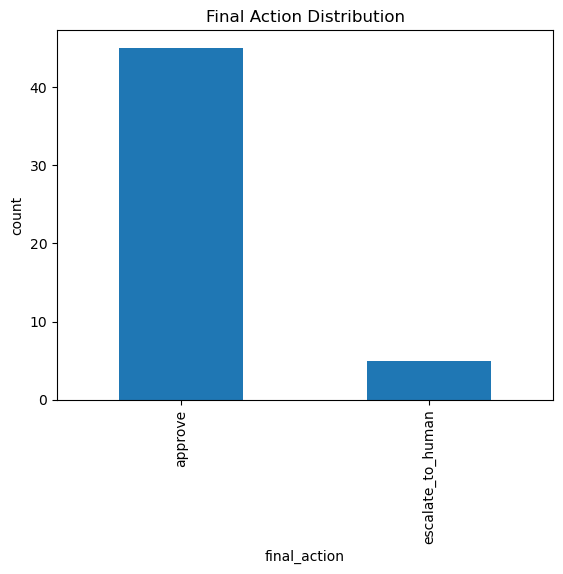

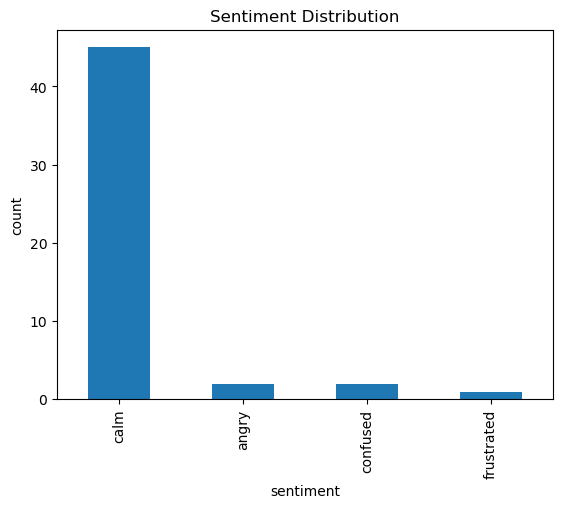

In [5]:
plt.figure()
action_counts.plot(kind="bar")
plt.title("Final Action Distribution")
plt.xlabel("final_action")
plt.ylabel("count")
plt.show()

plt.figure()
sentiment_counts.plot(kind="bar")
plt.title("Sentiment Distribution")
plt.xlabel("sentiment")
plt.ylabel("count")
plt.show()


In [6]:
approved = df[df["final_action"] == "approve"].copy()

approved_samples = approved[[
    "id",
    "subject",
    "category",
    "urgency",
    "sentiment",
    "final_action",
    "final_reply"
]].head(5)

approved_samples


,id,subject,category,urgency,sentiment,final_action,final_reply
0,1,Issue with my latest invoice,billing,normal,calm,approve,I’ve checked your billing details and I can he...
1,2,Requesting copy of last months invoice,billing,normal,calm,approve,I’ve checked your billing details and I can he...
2,3,Why is my bill different this month?,general_inquiry,normal,calm,approve,Here’s the information you requested.
4,5,Clarification needed on usage charges,billing,normal,calm,approve,I’ve checked your billing details and I can he...
5,6,VAT information missing,billing,normal,calm,approve,I’ve checked your billing details and I can he...


In [7]:
escalated = df[df["final_action"] == "escalate_to_human"].copy()

escalated_samples = escalated[[
    "id",
    "subject",
    "category",
    "urgency",
    "sentiment",
    "final_action",
    "needs_escalation",
    "supervisor_decision",
    "supervisor_notes"
]]

escalated_samples


,id,subject,category,urgency,sentiment,final_action,needs_escalation,supervisor_decision,supervisor_notes
3,4,Sudden increase in subscription fee,billing,normal,frustrated,escalate_to_human,True,None,None
7,8,Incorrect overcharge on my account,billing,normal,angry,escalate_to_human,True,None,None
30,31,Very disappointed with your service,complaint,normal,angry,escalate_to_human,True,None,None
36,37,Waiting for support for a week,complaint,normal,calm,escalate_to_human,False,None,None
39,40,Issue not fixed after multiple emails,general_inquiry,high,calm,escalate_to_human,True,None,None


In [8]:
def show_email_row(row):
    print(f"ID: {row['id']}")
    print(f"Subject: {row['subject']}")
    print(f"Category: {row['category']} | Urgency: {row['urgency']} | Sentiment: {row['sentiment']}")
    print(f"Final action: {row['final_action']}")
    print()
    print("Final reply:")
    print(row["final_reply"] or "[no auto reply – escalated to human]")
    print("-" * 60)

# Example: show first approved email
show_email_row(approved.iloc[0])


ID: 1
Subject: Issue with my latest invoice
Category: billing | Urgency: normal | Sentiment: calm
Final action: approve

Final reply:
I’ve checked your billing details and I can help clarify the recent changes.
------------------------------------------------------------


## Summary

- The pipeline processed 50 emails end-to-end.
- The Decision Agent routed 45 emails to the auto Reply Agent (`approve`) and escalated 5 to humans (`escalate_to_human`).
- Escalated cases correspond to emotionally charged or high-risk scenarios (e.g. frustration, anger, repeated unresolved issues).
- For approved emails, the Reply Agent generated professional responses that can be further fine-tuned for tone and length.

This notebook demonstrates:
- How a multi-agent system can triage support emails,
- How rule-based decision making can reduce unnecessary escalations,
- And how to analyse and debug the agents' behaviour using batch results.
